In [10]:
# last edited Feb 5 2021 by GO
# to do:  got as far as exporting SHP for Ecospace
#         must now write ASC. print the coords as-is to ASC will mirror 
#         the map vertically - next step is to fix that. 
#        

#
#############################################################################
# purpose: export Ecospace grid file from NEMO grid file
#
#      - note that Ecospace and NEMO have different grids
#        but the grid layout will be the same, so I need
#        a mapping of row_NEMO -> row_Ecospace
#                     col_NEMO -> row_Ecospace
#      - points represent cell centres ('t' points)
#      - NEMO using 0 based indexing (Python) from bottom left
#      - Ecospace using 0 based (?) from upper right
#
# in: NEMO-Salish-Sea-2021\data\grid\coordinates_salishsea_1500m.nc
#                                    bathy_salishsea_1500m_20210205.nc
# out: Ecosystem-Model-Data-Framework\data\basemap 
#
# header template: 
#ncols         56
#nrows         160
#xllcorner     -125.375
#yllcorner     45.2205657958984
#cellsize      0.0179964620620012
#NODATA_value  -9999
#############################################################################

%matplotlib notebook
import netCDF4 as nc
import numpy as np
import pandas as pd
import geopandas as gpd
from helpers import writebathy, expandf
from helpers import gete1, gete2, writecoords, t2u, t2v, t2f
import matplotlib.pyplot as plt
import scipy.io as sio

<IPython.core.display.Javascript object>


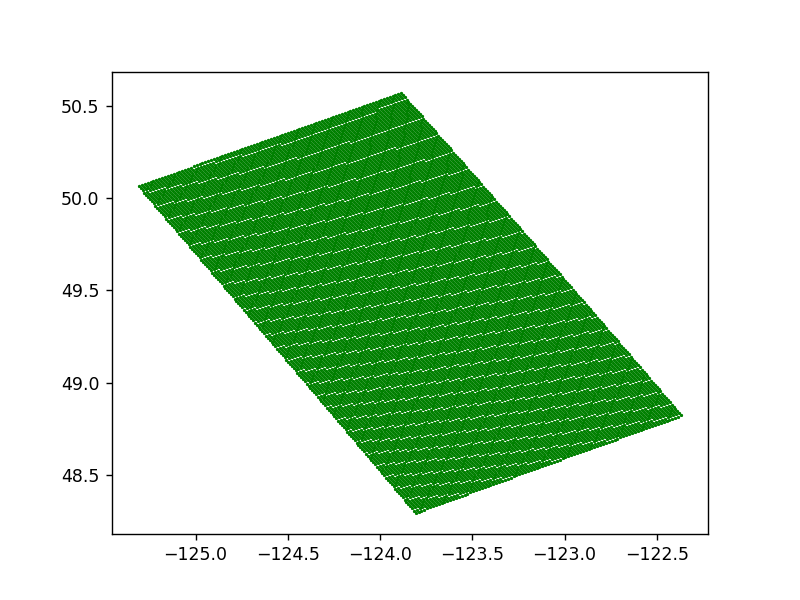

In [44]:
#For a full grid - coordfile
#for just water - bathy
coordfilename = '..//..//NEMO-Salish-Sea-2021//data//grid//coordinates_salishsea_1500m.nc'
bathyfilename = '..//..//NEMO-Salish-Sea-2021//data//bathymetry//bathy_salishsea_1500m_20210205.nc'
datetag = '20210205'
# NEMO grid upper left and bottom left pts that define the Ecospace grid. 
#   - Ecospace will use all cols to the right. 
upperleft_row_ewe = 253
upperleft_col_ewe = 39
bottomleft_row_ewe = 102
bottomleft_col_ewe = 39

# functions
def loadcoords(f): 
    with nc.Dataset(coordfilename) as ncid:
        lat_t = ncid.variables["gphit"][0, :, :].filled()
        lon_t = ncid.variables["glamt"][0, :, :].filled()
    return lat_t, lon_t


def loadbathy(f):
    with nc.Dataset(f) as ncid:
        depth = ncid.variables["Bathymetry"][:, :].filled()
        latt = ncid.variables["nav_lat"][:, :].filled()
        lont = ncid.variables["nav_lon"][:, :].filled()
        
    return depth, latt, lont

#############################################################################
########################### EXPORT NEMO GRID SHP ############################
# get coords
depth, lat_t, lon_t = loadbathy(bathyfilename)

i = 0 
coords = []
while i < len(lat_t[:,0]):
    
    coords_row = [list(coord) for coord in zip(lat_t[i,:], 
                                               lon_t[i,:], 
                                               depth[i,:], 
                                               np.arange(0,lat_t.shape[1]), 
                                               np.full((lat_t.shape[1]), i))]
    #print(lat_t[i,:])
    #print(lon_t[i,:])
    coords = coords + coords_row
    i += 1
    
#df = pd.DataFrame(coords)
#gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[1],df[0]), crs="EPSG:4326")
#gdf.plot( marker='*', color='green', markersize=1)
#gdf.rename(columns={0:'lat',1:'lon',2: 'depth', 3:'col',4:'row'}, inplace=True)
#gdf.to_file(driver = 'ESRI Shapefile', filename= "..//data//basemap//NEMO_grid_{}.shp".format(datetag))

#############################################################################
######################### EXPORT ECOSPACE GRID SHP ##########################

i = bottomleft_row_ewe 
j = 0 
coords = []
while i < upperleft_row_ewe:
    
    coords_row = [list(coord) for coord in zip(lat_t[i,upperleft_col_ewe:], 
                                               lon_t[i,upperleft_col_ewe:], 
                                               depth[i,upperleft_col_ewe:], 
                                               np.arange(upperleft_col_ewe,lat_t.shape[1]), # list of col nums
                                               np.full(lat_t.shape[1], i))] # list of the row num i cols long
    #print(coords_row[0]) 
    coords = coords + coords_row
    i += 1
    
df = pd.DataFrame(coords)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[1],df[0]), crs="EPSG:4326")
gdf.plot( marker='*', color='green', markersize=1)
gdf.rename(columns={0:'lat',1:'lon',2: 'depth', 3:'NEMO_col',4:'NEMO_row'}, inplace=True)
gdf.to_file(driver = 'ESRI Shapefile', filename= "..//data//basemap//Ecospace_grid_{}.shp".format(datetag))




In [15]:
"..//..//data//basemap//NEMO_grid_{}.shp".format(datetag)

'..//..//data//basemap//NEMO_grid_20210205.shp'

In [40]:
np.full(lat_t.shape[1], i)

array([102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102])

In [179]:
gdf

,0,1,2,3,4,geometry
0,46.864815,-123.426773,0.0,0,0,POINT (-123.42677 46.86481)
1,46.870636,-123.410965,0.0,1,0,POINT (-123.41096 46.87064)
2,46.876358,-123.395081,0.0,2,0,POINT (-123.39508 46.87636)
3,46.882050,-123.379173,0.0,3,0,POINT (-123.37917 46.88205)
4,46.887726,-123.363251,0.0,4,0,POINT (-123.36325 46.88773)
...,...,...,...,...,...,...
39463,51.072784,-124.406303,0.0,127,298,POINT (-124.40630 51.07278)
39464,51.077732,-124.391945,0.0,128,298,POINT (-124.39194 51.07773)
39465,51.082653,-124.377663,0.0,129,298,POINT (-124.37766 51.08265)
39466,51.087543,-124.363472,0.0,130,298,POINT (-124.36347 51.08754)
